In [1]:
import os
import cv2
import numpy as np
import random

from tqdm import tqdm
from utils import (
    overlay_image_with_blend, 
    gaussian_kernel, zip_folder)

from utils.algorithms import (
    perlin_noise, 
    generate_parallel_or_perpendicular_lines,
    generate_parallel_lines_adjacent)

import matplotlib.pyplot as plt

In [8]:
def entre(min_val, max_val, integer=False):
    """ Generate a random value between [min_val, max_val] """
    if integer:
        return random.randint(min_val, max_val)
    return random.uniform(min_val, max_val)

def generate_images(shape_image_base=(512, 512), gaussian_size_low=4, gaussian_size_high=40, num_lines_range=(2, 6), p=0.5):
    img = np.zeros(shape_image_base)
    img_tmp = np.zeros(shape_image_base)
    img_pretil = np.zeros(shape_image_base)
    img_pretil_binary = np.zeros(shape_image_base)
    img_zanja = np.zeros(shape_image_base)

    # Generate between 2 and 6 parallel or perpendicular lines
    num_lines = np.random.randint(num_lines_range[0], num_lines_range[1] + 1)
    num_rand = np.random.rand()

    if  num_rand < p:
        lines = generate_parallel_or_perpendicular_lines(shape_image_base, num_lines)
    else:
        lines = generate_parallel_lines_adjacent(shape_image_base)

    for idx, line in enumerate(lines):
        img_line = np.zeros(shape_image_base)
        random_size = entre(gaussian_size_low, gaussian_size_high, integer=True)
        for point in line:
            factor = entre(0.5, 1)
            gaussian_size = int(random_size * factor)

            if num_rand < p:
                gaussian = gaussian_kernel(gaussian_size, normalize=True)
            else:
                gaussian = gaussian_kernel(entre(28,35, integer=True), normalize=True) * -1 if idx == 1 else gaussian_kernel(entre(9,12, integer=True), normalize=True)
            img_line += overlay_image_with_blend(img_tmp, gaussian, position=point)
        
        if num_rand < p:
            img_line = img_line / np.max(img_line) * entre(0.5, 2.5)
            img = np.maximum(img, img_line)
        else:
            if idx == 1:
                img_line = img_line / np.min(img_line) * -entre(1, 2)
                img += img_line
            else:
                img_line = img_line / np.max(img_line) * entre(0.5, 2.5)
                img += img_line 
        
    # Overlay the lines on the image
    img_pretil = img.copy()
    img_pretil_binary = np.where(img >= 0.1, 1, 0)
    img_zanja = np.where(img <= -0.1, 1, 0)
    img_background = 1 - img_pretil_binary - img_zanja
    img_pretil = np.clip(img_pretil, -10, 10)

    img_class = np.stack((img_background, img_pretil_binary, img_zanja), axis=-1)
    print(img_class.shape)
    noise = perlin_noise((512, 512, 1), octaves=(entre(0.01, 0.02), entre(0.02, 0.04), entre(0.04, 0.08), entre(0.08, 0.1), entre(0.1, 0.2), entre(0.2, 0.3), entre(0.3, 1)))
    img += noise
    img = np.clip(img, -10, 10)

    return img, img_class, img_pretil

In [9]:
num_images = 10
dataset_path = 'dataset_val'

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
#else:
#    raise FileExistsError(f'Folder {dataset_path} already exists. Please remove it before running this script.')

gsd = 0.1  # Ground Sampling Distance (m/px)
shape_image_base = (512, 512)
pretril_size_low = np.round(0.4 / gsd)
pretil_size_high = np.round(4 / gsd)

for idx in tqdm(range(num_images)):
    img, img_class, img_pretil = generate_images(shape_image_base,pretril_size_low, pretil_size_high)
    img_class = (img_class * 255).astype(np.uint8)
    img_pretil = img_pretil.astype(np.half) 
    img = img.astype(np.half)

    np.savez_compressed(f'{dataset_path}/img_{idx}.npz', img)
    cv2.imwrite(f'{dataset_path}/img_class_{idx}.png', img_class)
    np.savez_compressed(f'{dataset_path}/img_pretil_{idx}.npz', img_pretil)
    

 10%|█         | 1/10 [00:00<00:04,  1.85it/s]

(512, 512, 3)


 20%|██        | 2/10 [00:00<00:03,  2.05it/s]

(512, 512, 3)


 30%|███       | 3/10 [00:01<00:03,  1.81it/s]

(512, 512, 3)


 40%|████      | 4/10 [00:01<00:02,  2.39it/s]

(512, 512, 3)


 50%|█████     | 5/10 [00:02<00:01,  2.79it/s]

(512, 512, 3)


 60%|██████    | 6/10 [00:02<00:01,  2.91it/s]

(512, 512, 3)


 70%|███████   | 7/10 [00:02<00:01,  2.56it/s]

(512, 512, 3)


 80%|████████  | 8/10 [00:03<00:00,  2.58it/s]

(512, 512, 3)


 90%|█████████ | 9/10 [00:03<00:00,  2.84it/s]

(512, 512, 3)


100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

(512, 512, 3)


In [19]:
zip_folder(dataset_path, f'{dataset_path}.zip')

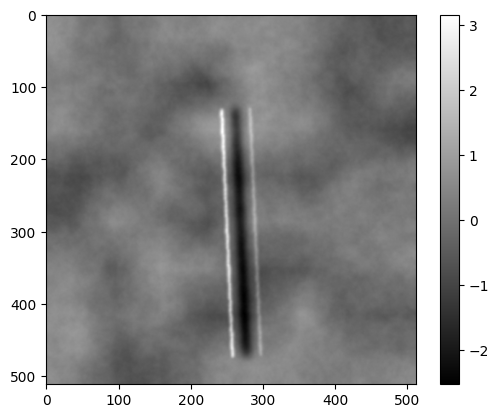

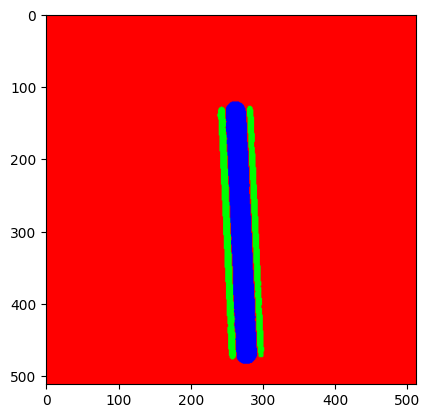

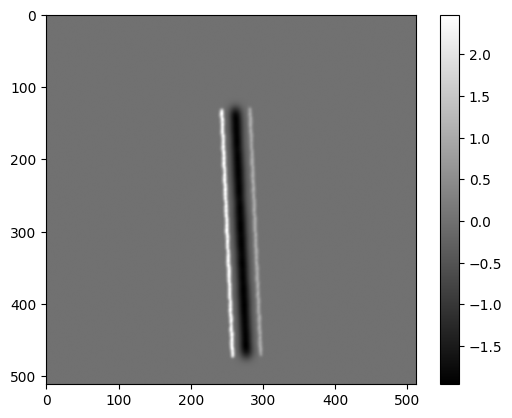

In [ ]:
# import cv2
# idx = 8
# img = np.load(f'dataset/img_{idx}.npz')['arr_0']
# img_class = cv2.imread(f'dataset/img_class_{idx}.png')
# img_pretil = np.load(f'dataset/img_pretil_{idx}.npz')['arr_0']

# plt.imshow(img, cmap='grey')
# plt.colorbar()
# plt.show()
# plt.imshow(img_class)
# plt.show()
# plt.imshow(img_pretil, cmap='grey')
# plt.colorbar()
# plt.show()